In [1]:
import tensorflow as tf
import cv2
import imageio
import pandas as pd
import numpy as np
from helpers_trans import Fy, find_closest_element, DensityPredictor
from scipy.stats import norm
import scipy.stats
import matplotlib.pyplot as plt


In [2]:
density_path = '../../../data/commaai/density/gaussian_density_filtered.csv'
density = pd.read_csv(density_path)

In [3]:
path_all_imgs = '../../../data/commaai/training_files_filtered/indices/train_indices.csv'
all_img_df = pd.read_csv(path_all_imgs)
img_path_base = '../../../data/commaai/train_bags_2/'
paths = img_path_base + all_img_df['path'][0:5]

In [38]:
path_all_imgs = '../../../data/commaai/training_files_filtered/indices/review.csv'
review_df_test = pd.read_csv(path_all_imgs)

In [4]:
paths = [ #'../../Parting_of_the_ways_-_geograph.org.uk_-_1325256.jpg',
         #'../../road-markings-madness.png',
         #'../../mountain-road-curve-to-right-fagaras-mountains-alpine-highway-43754624.jpg',
         '../../../data/commaai/train_bags_2/1/15_1241run1.png', # no lane markings
         '../../../data/commaai/train_bags_2/2/25_1293run1.png', # confusing lane markings
         '../../../data/commaai/train_bags_2/1/69_340run1.png', # clear lane markings
         '../../../data/commaai/train_bags_2/0/28_911run1.png', # stop & go traffic
         '../../../data/commaai/train_bags_2/0/149_912run1.png', # parting road
         '../../../data/commaai/train_bags_2/0/76_921run1.png', # bad lighting
         '../../../data/commaai/train_bags_2/0/15_947run1.png', # parting road
         '../../../data/commaai/train_bags_2/0/24_1000run1.png', # parting road
         '../../../data/commaai/train_bags_2/0/118_977run1.png', # left turn only half visible
         '../../../data/commaai/train_bags_2/0/80_436run1.png', # parting road, closer
         '../../../data/commaai/train_bags_2/0/121_254run1.png', # parting road, closer, other side
         '../../../data/commaai/train_bags_2/0/202_429run1.png', # bad view, 
         '../../../data/commaai/train_bags_2/0/4_500run1.png' #parting road
        ]

## compute predictive densities

In [5]:
predictor_va_prec = DensityPredictor('va_ridge', 'precise', 10)
predictor_va_prec.load_bzeta_model()
predictor_va_prec.predict_Bzeta(paths, True, False)
predictor_va_prec.choose_method('va_ridge')
predictor_va_prec.initialize_grid(density, 65536)
densities_va_prec = predictor_va_prec.predict_density()

building model ...
loading model weights ...
... finished loading weights.
start predicting Bzeta on images ...
... finished predicting Bzeta on images.
chose variational approximation with ridge prior as method
computing fixed values for density estimation ...
...finished computing fixed values.


In [6]:
predictor_hmc_prec_horse = DensityPredictor('hmc_horseshoe', 'precise', 10)
predictor_hmc_prec_horse.load_bzeta_model()
predictor_hmc_prec_horse.predict_Bzeta(paths, True, False)
predictor_hmc_prec_horse.choose_method('hmc_horseshoe')
predictor_hmc_prec_horse.initialize_grid(density, 65536)
densities_hmc_prec_horse = predictor_hmc_prec_horse.predict_density()

building model ...
loading model weights ...
... finished loading weights.
start predicting Bzeta on images ...
... finished predicting Bzeta on images.
chose variational approximation with ridge prior as method
computing fixed values for density estimation ...
...finished computing fixed values.


In [7]:
predictor_va_prec_horse = DensityPredictor('va_horseshoe', 'precise', 10)
predictor_va_prec_horse.load_bzeta_model()
predictor_va_prec_horse.predict_Bzeta(paths, True, False)
predictor_va_prec_horse.choose_method('va_horseshoe')
predictor_va_prec_horse.initialize_grid(density, 65536)
densities_va_prec_horse = predictor_va_prec_horse.predict_density()

building model ...
loading model weights ...
... finished loading weights.
start predicting Bzeta on images ...
... finished predicting Bzeta on images.
chose variational approximation with ridge prior as method
computing fixed values for density estimation ...
...finished computing fixed values.


In [8]:
predictor_hmc_prec = DensityPredictor('hmc_ridge', 'precise', 10)
predictor_hmc_prec.load_bzeta_model()
predictor_hmc_prec.predict_Bzeta(paths, True, False)
predictor_hmc_prec.choose_method('va_ridge')
predictor_hmc_prec.initialize_grid(density, 65536)
densities_hmc_prec = predictor_hmc_prec.predict_density()

building model ...
loading model weights ...
... finished loading weights.
start predicting Bzeta on images ...
... finished predicting Bzeta on images.
chose variational approximation with ridge prior as method
computing fixed values for density estimation ...
...finished computing fixed values.


## plot predictive densities

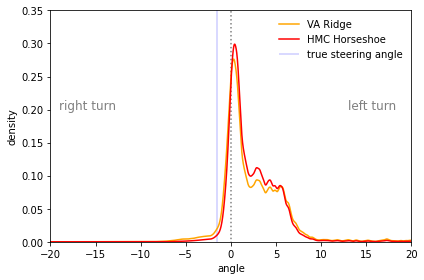

In [26]:
plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_va_prec[-3], color = 'orange', label = 'VA Ridge')
#plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_va_prec_horse[-3], color = 'purple', label = 'VA Horseshoe')
plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_hmc_prec_horse[-3], color = 'red', label = 'HMC Horseshoe')
#plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_hmc_prec[-3], color = 'orange', label = 'HMC Ridge')
plt.xlabel('angle')
plt.ylabel('density')
plt.xlim(-20,20)
plt.ylim(0,0.35)
plt.text(-19, 0.2, 'right turn', size=12, color='grey')
plt.text(13, 0.2, 'left turn', size=12, color='grey')
plt.vlines(x = 0, ymin = -1, ymax = 1, linestyle = 'dotted', color = 'grey')
plt.tight_layout()
plt.vlines(x = float(all_img_df[all_img_df['path'] == paths[-3][35:]]['angle']), ymin = -1, ymax = 1, color = 'blue', label = 'true steering angle', alpha = 0.2)
plt.legend(framealpha=0.0)
plt.savefig('../../../data/commaai/calibration/examples_viz/dens_121_254run1.png') 

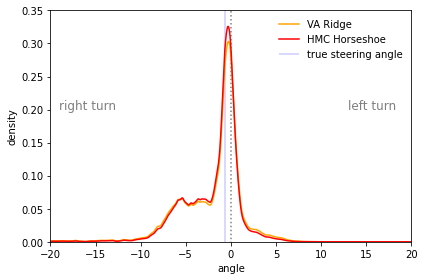

In [28]:
plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_va_prec[-4], color = 'orange', label = 'VA Ridge')
#plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_va_prec_horse[-4], color = 'purple', label = 'VA Horseshoe', linestyle = '-.')
plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_hmc_prec_horse[-4], color = 'red', label = 'HMC Horseshoe')
#plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_hmc_prec[-4], color = 'orange', label = 'HMC Ridge', linestyle = '-.')
plt.xlabel('angle')
plt.ylabel('density')
plt.xlim(-20,20)
plt.ylim(0,0.35)
plt.text(-19, 0.2, 'right turn', size=12, color='grey')
plt.text(13, 0.2, 'left turn', size=12, color='grey')
plt.vlines(x = 0, ymin = -1, ymax = 1, linestyle = 'dotted', color = 'grey')
plt.tight_layout()
plt.vlines(x = float(all_img_df[all_img_df['path'] == paths[-4][35:]]['angle']), ymin = -1, ymax = 1, color = 'blue', label = 'true steering angle', alpha = 0.2)
plt.legend(framealpha=0.0)
plt.savefig('../../../data/commaai/calibration/examples_viz/dens_80_436run1.png') 

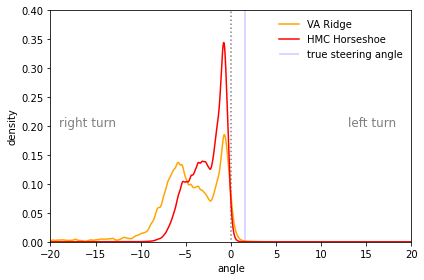

In [51]:
plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_va_prec[8], color = 'orange', label = 'VA Ridge')
#plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_va_prec_horse[-4], color = 'purple', label = 'VA Horseshoe', linestyle = '-.')
plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_hmc_prec_horse[8], color = 'red', label = 'HMC Horseshoe')
#plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_hmc_prec[-4], color = 'orange', label = 'HMC Ridge', linestyle = '-.')
plt.xlabel('angle')
plt.ylabel('density')
plt.xlim(-20,20)
plt.ylim(0,0.4)
plt.text(-19, 0.2, 'right turn', size=12, color='grey')
plt.text(13, 0.2, 'left turn', size=12, color='grey')
plt.vlines(x = 0, ymin = -1, ymax = 1, linestyle = 'dotted', color = 'grey')
plt.tight_layout()
plt.vlines(x = float(review_df_test[review_df_test['path'] == paths[8][35:]]['angle']), ymin = -1, ymax = 1, color = 'blue', label = 'true steering angle', alpha = 0.2)
plt.legend(framealpha=0.0)
plt.savefig('../../../data/commaai/calibration/examples_viz/dens_118_977run1.png') 

## plot images

In [43]:
def change_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v,value)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

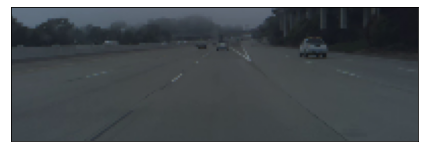

In [47]:
img = imageio.imread(paths[-4])
img = cv2.resize(img, dsize = (291,218), interpolation = cv2.INTER_LINEAR)[76:142, 45:245,0:3]/255
figure, ax = plt.figure(), plt.gca()
ax.imshow(img[:,:,0:3])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.tight_layout()
figure.savefig('../../../data/commaai/calibration/examples_viz/80_436run1.png', format='png', dpi=900)

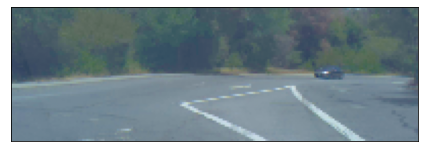

In [50]:
img = change_brightness(imageio.imread(paths[8]), value = 70)
img = cv2.resize(img, dsize = (291,218), interpolation = cv2.INTER_LINEAR)[76:142, 45:245,0:3]/255
figure, ax = plt.figure(), plt.gca()
ax.imshow(img[:,:,0:3])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.tight_layout()
figure.savefig('../../../data/commaai/calibration/examples_viz/118_977run1.png', format='png', dpi=900)